In [1]:
from __future__ import absolute_import, division, print_function
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Packages to support visualization
import base64
import imageio
import IPython
import PIL.Image
import pyvirtualdisplay
import matplotlib
import matplotlib.pyplot as plt

# Packages to support model training
import numpy as np
import tensorflow as tf
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Packages to support custom networks
import abc
from tf_agents.environments import random_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import encoding_network
from tf_agents.networks import network
from tf_agents.networks import utils
from tf_agents.specs import array_spec
from tf_agents.utils import common as common_utils
from tf_agents.utils import nest_utils

tf.compat.v1.enable_v2_behavior()

In [2]:
# Declare model constants
num_iterations = 10000
initial_collect_steps = 1000
collect_steps_per_iteration = 1  
replay_buffer_max_length = 100000  
batch_size = 64
learning_rate = 1e-3  
log_interval = 200  
num_eval_episodes = 10  
eval_interval = 1000

In [3]:
# Initialize environment
env_name = 'Pendulum-v0'
env = suite_gym.load(env_name)
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Display environment dimensions
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Reward Spec:')
print(env.time_step_spec().reward)
print('Action Spec:')
print(env.action_spec())
time_step = env.reset()
print('Time step:')
print(time_step)

Observation Spec:
BoundedArraySpec(shape=(3,), dtype=dtype('float32'), name='observation', minimum=[-1. -1. -8.], maximum=[1. 1. 8.])
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='action', minimum=-2.0, maximum=2.0)
Time step:
TimeStep(step_type=array(0), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.20445739,  0.97887546, -0.66475785], dtype=float32))


In [4]:
class ActorNetworkCustom(network.Network):

    def __init__(self,
                observation_spec,
                action_spec,
                name='ActorNetworkCustom'):
        super(ActorNetworkCustom, self).__init__(
            input_tensor_spec=observation_spec, state_spec=(), name=name)

        # For simplicity we will only support a single action float output.
        self._action_spec = action_spec
        flat_action_spec = tf.nest.flatten(action_spec)
        self._single_action_spec = flat_action_spec[0]

        # Initialize the custom tf layers here:
        self._dense1 = tf.keras.layers.Dense(400, name='Dense1')
        self._dense2 = tf.keras.layers.Dense(300, name='Dense2')
        initializer = tf.keras.initializers.RandomUniform(
            minval=-0.003, maxval=0.003)
        self._action_projection_layer = tf.keras.layers.Dense(
            flat_action_spec[0].shape.num_elements(),
            activation=tf.keras.activations.tanh,
            kernel_initializer=initializer,
            name='action')

    def call(self, observations, step_type=(), network_state=()):
        # We use batch_squash here in case the observations have a time sequence component.
        outer_rank = nest_utils.get_outer_rank(observations, self.input_tensor_spec)
        batch_squash = utils.BatchSquash(outer_rank)
        observations = tf.nest.map_structure(batch_squash.flatten, observations)

        # Forward pass through the custom tf layers here (defined above):
        state = self._dense1(observations)
        state = self._dense2(state)
        actions = self._action_projection_layer(state)

        actions = common_utils.scale_to_spec(actions, self._single_action_spec)
        actions = batch_squash.unflatten(actions)
        return tf.nest.pack_sequence_as(self._action_spec, [actions]), network_state

In [5]:
class CriticNetworkCustom(network.Network):

    def __init__(self,
                observation_spec,
                action_spec,
                name='CriticNetworkCustom'):
        # Invoke constructor of network.Network
        super(CriticNetworkCustom, self).__init__(
              input_tensor_spec=(observation_spec, action_spec), state_spec=(), name=name)

        self._obs_spec = observation_spec
        self._action_spec = action_spec

        # Encoding layer concatenates state and action inputs, adds dense layer:
        kernel_initializer = tf.keras.initializers.VarianceScaling(
            scale=1./3., mode='fan_in', distribution='uniform')
        combiner = tf.keras.layers.Concatenate(axis=-1)
        self._encoder = encoding_network.EncodingNetwork(
            (observation_spec, action_spec),
            fc_layer_params=(400,),
            preprocessing_combiner = combiner,
            activation_fn = tf.keras.activations.relu,
            kernel_initializer = kernel_initializer,
            batch_squash=True)

        # Initialize the custom tf layers here:
        self._dense1 = tf.keras.layers.Dense(400, name='Dense1')
        self._value_layer = tf.keras.layers.Dense(1,
                                                  activation=tf.keras.activations.linear,
                                                  name='Value') # Q-function output

    def call(self, observations, step_type=(), network_state=()):
        # Forward pass through the custom tf layers here (defined above):
        state, network_state = self._encoder(observations, 
                                             step_type=step_type, 
                                             network_state=network_state)
        state = self._dense1(state)
        value = self._value_layer(state)

        return tf.reshape(value,[-1]), network_state

In [6]:
act_net_custom = ActorNetworkCustom(train_env.observation_spec(),
                                    train_env.action_spec())

In [7]:
crit_net_custom = CriticNetworkCustom(train_env.observation_spec(), train_env.action_spec())

In [8]:
# Create the agent's actor and critic networks
act_net = actor_network.ActorNetwork(input_tensor_spec = train_env.observation_spec(),
                                     output_tensor_spec = train_env.action_spec(),
                                     fc_layer_params = (400,300),
                                     activation_fn = tf.keras.activations.relu                 
                                     )

crit_net = critic_network.CriticNetwork(input_tensor_spec = (train_env.observation_spec(), train_env.action_spec()),
                                        observation_fc_layer_params = (400,),
                                        action_fc_layer_params = None,
                                        joint_fc_layer_params = (400,),
                                        activation_fn = tf.keras.activations.relu
                                        )

In [9]:
# Linearly anneal the OU noise from 1.0 to 0.2 throughout the training
train_step_counter = tf.Variable(0)
global_step = tf.Variable(0, trainable=False)
starter_epsilon = 1.0
end_epsilon = 0.2
decay_steps = num_iterations + initial_collect_steps
ou_noise_size = tf.compat.v1.train.polynomial_decay(starter_epsilon,
                                                    train_step_counter,
                                                    decay_steps,
                                                    end_epsilon,
                                                    power=1.0,
                                                    cycle=False)

# Instantiate the agent and supply it with its actor and critic networks
actor_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
critic_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

agent = ddpg_agent.DdpgAgent(time_step_spec = train_env.time_step_spec(),
                             action_spec = train_env.action_spec(),
                             actor_network = act_net_custom, # act_net,
                             critic_network = crit_net_custom, # crit_net, # crit_net_custom, # crit_net,
                             actor_optimizer = actor_optimizer,
                             critic_optimizer = critic_optimizer, 
                             gamma = 0.99,
                             target_critic_network = None, # Target network = same as primary
                             target_update_tau = 0.1, 
                             ou_stddev = 1, 
                             ou_damping = 0.25,
                             td_errors_loss_fn = common.element_wise_squared_loss,
                             train_step_counter=train_step_counter
                             )

agent.initialize()

In [10]:
# crit_net.summary()
crit_net_custom.summary()

Model: "CriticNetworkCustom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  2000      
_________________________________________________________________
Dense1 (Dense)               multiple                  160400    
_________________________________________________________________
Value (Dense)                multiple                  401       
Total params: 162,801
Trainable params: 162,801
Non-trainable params: 0
_________________________________________________________________


In [11]:
act_net_custom.summary()

Model: "ActorNetworkCustom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               multiple                  1600      
_________________________________________________________________
Dense2 (Dense)               multiple                  120300    
_________________________________________________________________
action (Dense)               multiple                  301       
Total params: 122,201
Trainable params: 122,201
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Declare the function that will measure the training progress of the agent
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [13]:
# Create the replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,  
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

In [14]:
# Create the function that performs the action on the environment and adds the data to the replay buffer
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

In [15]:
# Compute performance baseline using random actions
example_environment = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-1261.364

In [16]:
# Peform functions required before entering the training loop
collect_data(train_env, random_policy, replay_buffer, steps=100)
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
print(returns)

[-1217.5613]


In [17]:
# Execute the main training loop
for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}, noise = {2}'.format(step, train_loss, float(np.round(np.array(ou_noise_size()),2))))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 200: loss = 15.643059730529785, noise = 0.9900000095367432
step = 400: loss = 33.24119567871094, noise = 0.9700000286102295
step = 600: loss = 81.01979064941406, noise = 0.9599999785423279
step = 800: loss = 30.171234130859375, noise = 0.9399999976158142
step = 1000: loss = 31.92599105834961, noise = 0.9300000071525574
step = 1000: Average Return = -1307.40869140625
step = 1200: loss = 39.701663970947266, noise = 0.9100000262260437
step = 1400: loss = 49.43059539794922, noise = 0.8999999761581421
step = 1600: loss = 449.8203430175781, noise = 0.8799999952316284
step = 1800: loss = 38.048057556152344, noise = 0.8700000047683716
step = 2000: loss = 39.66754150390625, noise = 0.8500000238418579
step = 2000: Average Return = -1057.450439453125
step = 2200: loss = 263.57574462890625, noise = 0.8399999737739563
step = 2400: loss = 47.811912536621094, noise = 0.8299999833106995
step = 2600: loss = 41.00938415527344, noise = 0.8100000023841858
step = 2800: loss = 74.29319763183594, nois

Text(0.5, 0, 'Iterations')

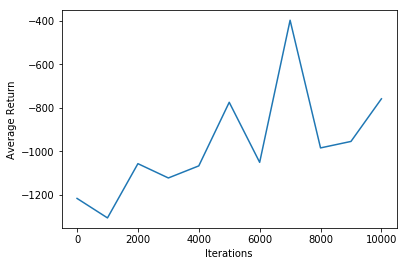

In [18]:
# Visualize the training progress of the agent
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

In [19]:
# Visualize the agent performing its learned behaviour
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = eval_env.step(action_step.action)
            video.append_data(eval_py_env.render())
    return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")
# create_policy_eval_video(random_policy, "random-agent")

W0610 08:50:51.761600 17724 _io.py:418] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
